#Imports

In [ ]:
import pylab
from sklearn.datasets import make_classification
import numpy as np
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

# pick the seed for reproducability - change it to explore the effects of random variations
np.random.seed(1)
import random

## Toy Problem

To begin with, let's start with a toy problem, where we have two input features. For example, in medicine we may want to classify tumours into benign and malignant, depending on its size and age.

We will generate a random classification dataset using `make_classification` function from SciKit Learn library:

In [ ]:
n = 50
X, Y = make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0)
Y = Y*2-1 # convert initial 0/1 values into -1/1
X = X.astype(np.float32); Y = Y.astype(np.int32) # features - float, label - int

# Split the dataset into training and test
train_x, test_x = np.split(X, [ n*8//10])
train_labels, test_labels = np.split(Y, [n*8//10])
print("Features:\n",train_x[0:4])
print("Labels:\n",train_labels[0:4])

Features:
 [[-1.7441838  -1.3952037 ]
 [ 2.5921783  -0.08124504]
 [ 0.9218062   0.91789985]
 [-0.8437018  -0.18738253]]
Labels:
 [-1 -1  1 -1]


Let's also plot the dataset:

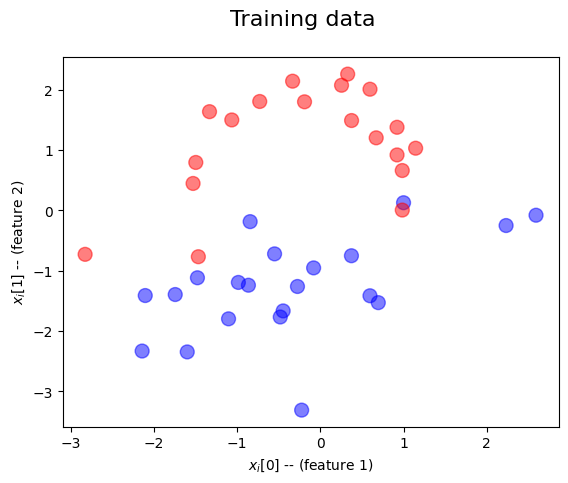

In [ ]:
def plot_dataset(suptitle, features, labels):
    # prepare the plot
    fig, ax = pylab.subplots(1, 1)
    #pylab.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle, fontsize = 16)
    ax.set_xlabel('$x_i[0]$ -- (feature 1)')
    ax.set_ylabel('$x_i[1]$ -- (feature 2)')

    colors = ['r' if l>0 else 'b' for l in labels]
    ax.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
    fig.show()

plot_dataset('Training data', train_x, train_labels)

## Perceptron

Since perceptron is a binary classifier, for each input vector $x$ the output of our perceptron would be either +1 or -1, depending on the class. The output will be computed using the formula

$$y(\mathbf{x}) = f(\mathbf{w}^{\mathrm{T}}\mathbf{x})$$

where $\mathbf{w}$ is a weight vector, $f$ is a step activation function:
$$
f(x) = \begin{cases}
         +1 & x \geq 0 \\
         -1 & x < 0
       \end{cases} \\
$$

However, a generic linear model should also have a bias, i.e. ideally we should compute $y$ as $y=f(\mathbf{w}^{\mathrm{T}}\mathbf{x}+\mathbf{b})$. To simplify our model, we can get rid of this bias term by adding one more dimension to our input features, which always equals to 1:

In [ ]:
pos_examples = np.array([ [t[0], t[1], 1] for i,t in enumerate(train_x)
                          if train_labels[i]>0])
neg_examples = np.array([ [t[0], t[1], 1] for i,t in enumerate(train_x)
                          if train_labels[i]<0])
print(pos_examples[0:3])

[[ 0.92180622  0.91789985  1.        ]
 [-1.06435513  1.49764717  1.        ]
 [ 0.32839951  2.25677919  1.        ]]


## Training Algorithm

In order to train the perceptron, we need to find out weights $\mathbf{w}$ that will minimize the error. The error is defined using **perceptron criteria**:

$$E(\mathbf{w}) = -\sum_{n \in \mathcal{M}}\mathbf{w}^{\mathrm{T}}\mathbf{x}_{n}t_{n}$$

  * $t_{n} \in \{-1, +1\}$ for negative and positive training samples, respectively
  * $\mathcal{M}$ - a set of wrongly classified examples
  
We will use the process of **gradient descent**. Starting with some initial random weights $\mathbf{w}^{(0)}$, we will adjust weights on each step of the training using the gradient of $E$:

$$\mathbf{w}^{\tau + 1}=\mathbf{w}^{\tau} - \eta \nabla E(\mathbf{w}) = \mathbf{w}^{\tau} + \eta\sum_{n \in \mathcal{M}}\mathbf{x}_{n} t_{n}$$

where $\eta$ is a **learning rate**, and $\tau\in\mathbb{N}$ - number of iteration.

Let's define this algorithm in Python:

In [ ]:
class SimplePerceptron:
    def __init__(self, positive_examples, negative_examples,report_frequency=10):
        """
        Initialize the SimplePerceptron.

        :param report_frequency: How often (in epochs) we want to report accuracy.
        :param positive_examples: Numpy array of shape (num_pos_samples, num_features)
                                 containing all positive samples.
        :param negative_examples: Numpy array of shape (num_neg_samples, num_features)
                                 containing all negative samples.
        """
        self.positive_examples = positive_examples
        self.negative_examples = negative_examples
        self.report_frequency = report_frequency
        self.weights = None

    def train(self, epochs=100):
        """
        Train the SimplePerceptron on positive and negative examples for a given number of epochs.

        :param epochs: Number of epochs to train.
        """
        # Determine dimensionality and initialize weights if not already done
        num_dims = self.positive_examples.shape[1]
        if self.weights is None:
            self.weights = np.zeros((num_dims, 1))

        pos_count = self.positive_examples.shape[0]
        neg_count = self.negative_examples.shape[0]

        for epoch in range(epochs):
            # Pick one positive and one negative example at random
            pos = random.choice(self.positive_examples)
            neg = random.choice(self.negative_examples)

            # Update weights if positive example is classified incorrectly
            z_pos = np.dot(pos, self.weights)
            if z_pos < 0:
                self.weights += pos.reshape(self.weights.shape)

            # Update weights if negative example is classified incorrectly
            z_neg = np.dot(neg, self.weights)
            if z_neg >= 0:
                self.weights -= neg.reshape(self.weights.shape)

            # Periodically print current accuracy
            if epoch % self.report_frequency == 0:
                pos_out = np.dot(self.positive_examples, self.weights)
                neg_out = np.dot(self.negative_examples, self.weights)
                pos_correct = (pos_out >= 0).sum() / float(pos_count)
                neg_correct = (neg_out < 0).sum() / float(neg_count)
                print(f"Epoch={epoch}, pos correct={pos_correct}, neg correct={neg_correct}")

        return self.weights

Now let's run the training on our dataset:

In [ ]:
SimplePerceptron = SimplePerceptron(pos_examples,neg_examples)
wts = SimplePerceptron.train(100)

Epoch=0, pos correct=0.631578947368421, neg correct=1.0
Epoch=10, pos correct=0.7894736842105263, neg correct=1.0
Epoch=20, pos correct=0.8947368421052632, neg correct=0.8571428571428571
Epoch=30, pos correct=0.8947368421052632, neg correct=0.9523809523809523
Epoch=40, pos correct=0.8421052631578947, neg correct=1.0
Epoch=50, pos correct=0.8947368421052632, neg correct=0.9523809523809523
Epoch=60, pos correct=0.8421052631578947, neg correct=1.0
Epoch=70, pos correct=0.9473684210526315, neg correct=0.9047619047619048
Epoch=80, pos correct=0.9473684210526315, neg correct=0.9523809523809523
Epoch=90, pos correct=0.8421052631578947, neg correct=1.0


As you can see, initial accuracy is around 50%, but it quickly increases to higher values close to 90%.

Let's visualize how classes are separated. Our classification function looks like $\mathbf{w}^Tx$, and it is greater than 0 for one class, and is below 0 for another. Thus, class separation line is defined by $\mathbf{w}^Tx = 0$. Since we have only two dimensions $x_0$ and $x_1$, the equation for the line would be $w_0x_0+w_1x_1+w_2 = 0$ (remember that we have explicitly defined an extra dimension $x_2=1$). Let's plot this line:

In [ ]:
def plot_boundary(positive_examples, negative_examples, weights):
    if np.isclose(weights[1], 0):
        if np.isclose(weights[0], 0):
            x = y = np.array([-6, 6], dtype = 'float32')
        else:
            y = np.array([-6, 6], dtype='float32')
            x = -(weights[1] * y + weights[2])/weights[0]
    else:
        x = np.array([-6, 6], dtype='float32')
        y = -(weights[0] * x + weights[2])/weights[1]

    pylab.xlim(-6, 6)
    pylab.ylim(-6, 6)
    pylab.plot(positive_examples[:,0], positive_examples[:,1], 'bo')
    pylab.plot(negative_examples[:,0], negative_examples[:,1], 'ro')
    pylab.plot(x, y, 'g', linewidth=2.0)
    pylab.show()

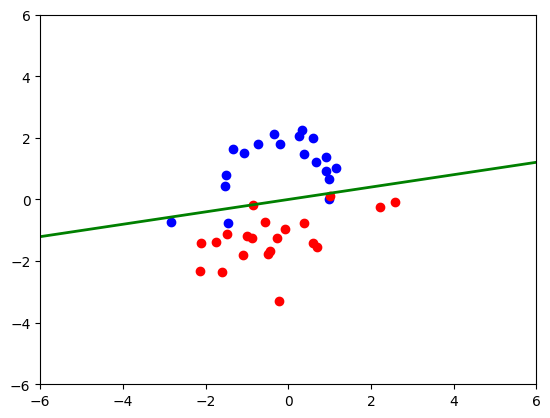

In [ ]:
plot_boundary(pos_examples,neg_examples,wts)

## Evaluate on Test Dataset

In the beginning, we have put apart some data to the test dataset. Let's see how accurate our classifier is on this test dataset. In order to do this, we also expand the test dataset with an extra dimension, multiply by weights matrix, and make sure that the obtained value is of the same sign as the label (+1 or -1). We then add together all boolean values and divide by the length of test sample, to obtain the accuracy:

In [ ]:
def accuracy(weights, test_x, test_labels):
    res = np.dot(np.c_[test_x,np.ones(len(test_x))],weights)
    return (res.reshape(test_labels.shape)*test_labels>=0).sum()/float(len(test_labels))

accuracy(wts, test_x, test_labels)

1.0

## Observing the training process

We have seen before how the accuracy decreases during training. It would be nice to see how the separation line behaves during training. The code below will visualize everything on one graph, and you should be able to move the slider to "time-travel" through the training process.

In [ ]:
class PerceptronTrainerGraph:
    def __init__(self, report_frequency=15):
        """
        Initializes the PerceptronTrainerGraph.

        :param report_frequency: How often to record snapshots during training.
        """
        self.report_frequency = report_frequency
        self.weights = None
        self.snapshots = None

    def train(self, positive_examples, negative_examples, num_iterations=100):
        """
        Trains the perceptron and stores snapshots of its performance.

        :param positive_examples: Numpy array of shape (num_positive, num_features).
        :param negative_examples: Numpy array of shape (num_negative, num_features).
        :param num_iterations:   Number of training iterations.
        :return:                 Numpy array of snapshots, where each snapshot includes
                                 the weights and a small list storing accuracy metrics.
        """
        # Initialize weights to 0 if not yet defined
        num_dims = positive_examples.shape[1]
        if self.weights is None:
            self.weights = np.zeros((num_dims, 1))

        pos_count = positive_examples.shape[0]
        neg_count = negative_examples.shape[0]

        # Store snapshots at defined intervals
        snapshots = []

        for i in range(num_iterations):
            # Pick one positive and one negative example at random
            pos = random.choice(positive_examples)
            neg = random.choice(negative_examples)

            # Update weights if the positive example is misclassified
            if np.dot(pos, self.weights) < 0:
                self.weights += pos.reshape(self.weights.shape)

            # Update weights if the negative example is misclassified
            if np.dot(neg, self.weights) >= 0:
                self.weights -= neg.reshape(self.weights.shape)

            # Record a snapshot every 'report_frequency' iterations
            if i % self.report_frequency == 0:
                pos_out = np.dot(positive_examples, self.weights)
                neg_out = np.dot(negative_examples, self.weights)
                pos_correct = (pos_out >= 0).sum() / float(pos_count)
                neg_correct = (neg_out < 0).sum() / float(neg_count)
                accuracy = (pos_correct + neg_correct) / 2.0
                # Create an entry combining flattened weights + a list for other data
                snapshots.append((np.concatenate(self.weights), [accuracy, 0, 0]))

        self.snapshots = np.array(snapshots, dtype=object)
        return self.snapshots

    def plot(self, pos_examples, neg_examples, step, plot_boundary_function):
        """
        Plots the decision boundary at a specific training 'step', as well as
        the recorded accuracy over training snapshots.

        :param pos_examples:           Numpy array of positive examples.
        :param neg_examples:           Numpy array of negative examples.
        :param step:                   Index in self.snapshots to visualize.
        :param plot_boundary_function: A function that draws the decision boundary,
                                       e.g. the user's existing 'plot_boundary' method.
        """
        if self.snapshots is None:
            raise ValueError("No snapshots to plot. Make sure to call train() first.")
        if step < 0 or step >= len(self.snapshots):
            raise IndexError(f"Step must be between 0 and {len(self.snapshots)-1}.")

        fig = pylab.figure(figsize=(10, 4))

        # Left subplot: decision boundary
        ax1 = fig.add_subplot(1, 2, 1)
        # The first item in self.snapshots[step] is the flattened weights
        plot_boundary_function(pos_examples, neg_examples, self.snapshots[step][0])
        ax1.set_title(f"Decision Boundary at step={step}")

        # Right subplot: accuracy over time
        ax2 = fig.add_subplot(1, 2, 2)
        # The second item in self.snapshots is a small list storing [accuracy, 0, 0]
        accuracies = [snap[1][0] for snap in self.snapshots]
        ax2.plot(np.arange(len(accuracies)), accuracies)
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Snapshot Index')
        ax2.plot(step, self.snapshots[step][1][0], "bo")
        ax2.set_title("Accuracy Over Snapshots")

        pylab.show()

trainer = PerceptronTrainerGraph(report_frequency=15)
snapshots = trainer.train(pos_examples, neg_examples, num_iterations=100)

def plotit(pos_examples,neg_examples,snapshots,step):
    fig = pylab.figure(figsize=(10,4))
    fig.add_subplot(1, 2, 1)
    plot_boundary(pos_examples, neg_examples, snapshots[step][0])
    fig.add_subplot(1, 2, 2)
    pylab.plot(np.arange(len(snapshots[:,1])), snapshots[:,1])
    pylab.ylabel('Accuracy')
    pylab.xlabel('Iteration')
    pylab.plot(step, snapshots[step,1][0], "bo")
    pylab.show()
def pl1(step): plotit(pos_examples,neg_examples,snapshots,step)

In [ ]:
interact(pl1, step=widgets.IntSlider(value=0, min=0, max=len(snapshots)-1))

interactive(children=(IntSlider(value=0, description='step', max=6), Output()), _dom_classes=('widget-interact…

<function __main__.pl1(step)>

## Limitations of the Perceptron

As you have seen above, perceptron is a **linear classifier**. It can distinguish between two classes well if they are **linearly separable**, i.e. can be separated by a straight line. Otherwise, perceptron training process will not converge.

A most obvious example of a problem that cannot be solved by a perceptron is so-called **XOR problem**. We want our perceptron to learn the XOR boolean function, which has the following truth table:

|   | 0 | 1 |
|---|---|---|
| 0 | 0 | 1 |
| 1 | 1 | 0 |

Let's try and do that! We will manually populate all positive and negative training samples, and then call our train function defined above:

In [ ]:
pos_examples_xor = np.array([[1,0,1],[0,1,1]])
neg_examples_xor = np.array([[1,1,1],[0,0,1]])

trainer_xor = PerceptronTrainerGraph(report_frequency=15)
snapshots_xor = trainer_xor.train(pos_examples, neg_examples, num_iterations=100)
def pl2(step): plotit(pos_examples_xor,neg_examples_xor,snapshots_xor,step)

In [ ]:
interact(pl2, step=widgets.IntSlider(value=0, min=0, max=len(snapshots)-1))

interactive(children=(IntSlider(value=0, description='step', max=6), Output()), _dom_classes=('widget-interact…

<function __main__.pl2(step)>

#Part2: Logistic Regression

##Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.datasets import make_classification

# Enable inline plotting
%matplotlib inline

##Logistic Regression Theory

Logistic regression is a fundamental method for binary classification. It models the probability that an example belongs to a particular class using the **sigmoid** function:

$$ h_{\theta}(x) = \frac{1}{1+e^{-\theta^T x}} $$

The cost function used to train the model is given by:

$$ J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}\Big[y^{(i)}\log(h_{\theta}(x^{(i)})) + (1-y^{(i)})\log(1-h_{\theta}(x^{(i)}))\Big] $$

We use **gradient descent** to iteratively update the parameters:

$$ \theta := \theta - \alpha \nabla J(\theta) $$



##Synthetic Binary Classification

In this experiment, we generate a **linearly separable** dataset using `make_classification`. We will pretend it’s analogous to a typical two-feature binary classification scenario. The dataset contains two features (X[:,0] and X[:,1]) and a binary target (y).

In [ ]:
# Create a synthetic, linearly separable dataset
def load_data():
    X, y = make_classification(
        n_samples=100, n_features=2,
        n_informative=1, n_redundant=0,
        n_clusters_per_class=1,
        class_sep=0.5,  # Increase separation for easy linear separability
        random_state=42
    )
    return X, y

# Load synthetic dataset
X_train, y_train = load_data()

print("First five elements in X_train:")
print(X_train[:5])
print("First five elements in y_train:")
print(y_train[:5])
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Number of training examples:", len(y_train))

### Visualizing the Data

Let's plot the two features. Here, points labeled `1` and `0` are marked differently.

In [ ]:
def plot_data(X, y):
    class1 = X[y == 1]
    class0 = X[y == 0]
    plt.scatter(class1[:, 0], class1[:, 1], marker='+', color='k', label='Class 1')
    plt.scatter(class0[:, 0], class0[:, 1], marker='o', color='y', label='Class 0')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()

plot_data(X_train, y_train)

## Logistic Regression Implementation

Below, we define the sigmoid function, the cost function, and the gradient descent algorithm to train our logistic regression model.

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_cost(theta, X, y):
    m = len(y)
    h = sigmoid(X.dot(theta))
    epsilon = 1e-5  # to avoid log(0)
    cost = (-1/m) * (np.dot(y, np.log(h + epsilon)) + np.dot((1-y), np.log(1-h + epsilon)))
    return cost

def gradient_descent(X, y, theta, alpha, num_iters):
    m = len(y)
    cost_history = []
    for i in range(num_iters):
        h = sigmoid(X.dot(theta))
        theta -= (alpha/m) * (X.T.dot(h - y))
        cost_history.append(compute_cost(theta, X, y))
    return theta, cost_history

# Add intercept term to our synthetic data
X_train_with_intercept = np.concatenate([np.ones((X_train.shape[0], 1)), X_train], axis=1)
theta_initial = np.zeros(X_train_with_intercept.shape[1])

# Run gradient descent
theta_final, cost_history = gradient_descent(X_train_with_intercept, y_train, theta_initial, alpha=0.01, num_iters=1500)
print("Final cost:", cost_history[-1])

### Plotting the Decision Boundary

The decision boundary is given by the equation:

$$ \theta_0 + \theta_1 x_1 + \theta_2 x_2 = 0 $$

We plot this boundary along with the data.

In [ ]:
def plot_decision_boundary(theta, X, y):
    # Remove the intercept term for plotting the features
    X_without_intercept = X[:, 1:]

    # Plot the training data
    plt.figure()
    class1 = X_without_intercept[y == 1]
    class0 = X_without_intercept[y == 0]
    plt.scatter(class1[:, 0], class1[:, 1], marker='+', color='k', label='Class 1')
    plt.scatter(class0[:, 0], class0[:, 1], marker='o', color='y', label='Class 0')

    # 1) Define x-axis values based on the min and max of Feature 1
    x_min, x_max = X_without_intercept[:, 0].min(), X_without_intercept[:, 0].max()
    plot_x = np.array([x_min, x_max])

    # 2) Calculate the decision boundary line
    #    theta0 + theta1*x + theta2*y = 0  =>  y = -(theta0 + theta1*x)/theta2
    plot_y = -(theta[0] + theta[1]*plot_x) / theta[2]

    # Plot the decision boundary
    plt.plot(plot_x, plot_y, 'b', label='Decision Boundary')

    # 3) Set the x and y limits to keep data and boundary nicely visible
    #    You can adjust the margins (like +1, -1) as needed.
    plt.xlim(x_min - 1, x_max + 1)
    y_min, y_max = X_without_intercept[:, 1].min(), X_without_intercept[:, 1].max()
    plt.ylim(y_min - 1, y_max + 1)

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()



plot_decision_boundary(theta_final, X_train_with_intercept, y_train)

### Evaluating the Model

We predict the class labels using a threshold of 0.5 and compute the training accuracy.

In [ ]:
def predict(theta, X):
    return sigmoid(X.dot(theta)) >= 0.5

predictions = predict(theta_final, X_train_with_intercept)
accuracy = accuracy_score(y_train, predictions)
print("Training accuracy: {:.2f}%".format(accuracy * 100))

#Perceptron VS Logistic Regression

In this note, we see the implementation of **Logistic Regression** and the **Perceptron** algorithm. Below are a few questions comparing these two methods, followed by concise answers for each.

---

### 1. How do Logistic Regression and the Perceptron differ in terms of their decision boundaries?

**Answer**:  
- Both algorithms produce linear decision boundaries.  
- **Logistic Regression** finds a boundary that maximizes the likelihood of the data (by minimizing cross-entropy loss). The boundary typically balances margin and correct classification to achieve the best probabilistic separation.  
- **Perceptron** simply seeks *any* linear boundary that can separate the classes (if they are indeed linearly separable). It updates the boundary only on misclassified examples. If the data is perfectly separable, it will find a solution, but not necessarily the “best” margin.

---

### 2. What are the key differences in the outputs of Logistic Regression and the Perceptron?

**Answer**:  
- **Logistic Regression** outputs a *probability* (between 0 and 1) that an example belongs to the positive class. This allows for a probabilistic interpretation and confidence measure.  
- **Perceptron** outputs a *hard classification* (0 or 1) without a probability. There is no direct way to measure how confident the model is in its prediction.

---

### 3. Under what conditions does the Perceptron converge, and how does this compare to Logistic Regression?

**Answer**:  
- The **Perceptron** converges in a *finite* number of steps if (and only if) the data is linearly separable. If it is not perfectly separable, the Perceptron may never converge and can keep updating the weights indefinitely.  
- **Logistic Regression** will *always converge* to a set of parameters that locally minimize the logistic (cross-entropy) loss, regardless of whether the data is linearly separable. It may not perfectly separate the data, but it will find an optimal solution in the sense of minimizing the cost function.

---

### 4. How does each algorithm handle misclassified examples?

**Answer**:  
- **Logistic Regression** penalizes misclassified examples by increasing the cost via the log loss. The gradient descent update takes into account *all* training examples in each iteration (or subsets in stochastic/mini-batch gradient descent), adjusting the parameters smoothly in proportion to the degree of misclassification.  
- **Perceptron** updates the weights *only* when it encounters a misclassified example. The update is a fixed step (scaled by the learning rate) in the direction of the correctly labeled class. If an example is classified correctly, no update occurs.


---

### 5. How do the two algorithms behave when the data is not linearly separable?

**Answer**:  
- **Logistic Regression** still finds the best fit in terms of minimizing the logistic loss, even if the data is not perfectly separable. It will produce a boundary that yields the highest possible likelihood under a linear assumption.  
- **Perceptron** may fail to converge if the data is not linearly separable. It might keep updating the boundary forever (or for a very large number of iterations), never finding a perfect separation.

---
